In [16]:
import pandas as pd
import numpy as np
import requests
import datetime
from datetime import datetime
import time
import json
import arch
import os
from statsmodels.tsa import stattools, arima 
import pmdarima as pm

C:\Users\jara_\Anaconda3\lib\site-packages\pmdarima\utils\visualization.py:222: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


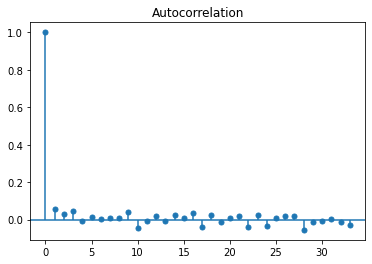

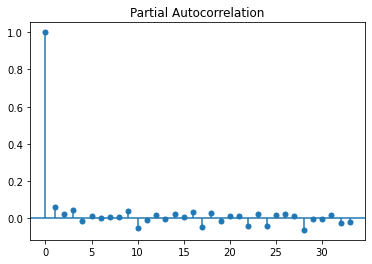

In [17]:
path = os.getcwd() + '\\Data'
files = os.listdir(path)
returns_df_path = [x for x in files if 'returns' in x]
returns_df = pd.read_csv(path + '\\' + returns_df_path[0])
reddit_df = [x for x in files if 'reddit' in x]
returns_df['Date'] = pd.to_datetime(returns_df['Date'])
returns_df = returns_df.sort_values(by = 'Date')
returns_df = returns_df[returns_df['Date'].dt.year >= 2015]
returns_garch = returns_df[returns_df['Date'].dt.year < 2021]
pm.arima.ndiffs(returns_df['Return'])
pm.arima.nsdiffs(returns_df['Return'], m = 7)
diff_series = returns_df.Return.diff()
pm.plot_acf(diff_series.dropna())
pm.plot_pacf(diff_series.dropna())

In [18]:
arima_component = pm.auto_arima(returns_garch['Return'], max_p = 5, 
                                       max_q = 5, m =7, max_P = 5, 
                                       max_Q = 5, max_D = 2,
                                       seasonal = True, trace = False)
arima_component.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1511
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -7453.732
Date:                Wed, 12 May 2021   AIC                          14913.465
Time:                        18:38:37   BIC                          14929.424
Sample:                             0   HQIC                         14919.408
                               - 1511                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7170      0.154      4.644      0.000       0.414       1.020
ma.L1         -0.6675      0.166     -4.010      0.000      -0.994      -0.341
sigma2      1134.9560     26.354     43.067      0.000    1083.304    1186.608
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               658.68
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.38
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\jara_\Anaconda3\lib\site-packages\pmdarima\utils\visualization.py:222: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead
  vlines_kwargs=vlines_kwargs, **kwargs)


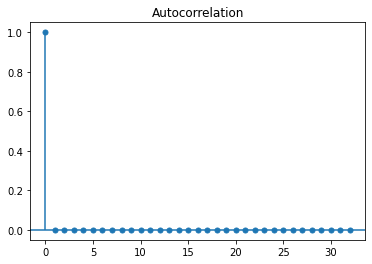

C:\Users\jara_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='Date'>

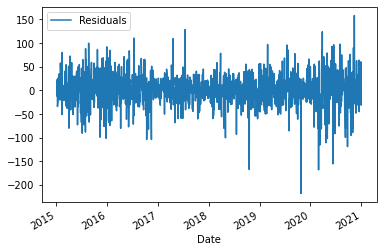

In [19]:
residuals = arima_component.resid()
pm.plot_acf(np.square(residuals))
returns_garch['Residuals'] = residuals.tolist()
returns_resid = returns_garch.iloc[1:]
returns_resid.plot(x = 'Date', y = 'Residuals')

In [20]:
reddit_scrape = pd.read_csv(path + '\\' + reddit_df[0])
reddit_scrape.columns = ['Index', 'Times', 'Heatwave', 'Date']
reddit_scrape['Date'] = pd.to_datetime(reddit_scrape['Date'])
reddit_scrape['Date']

0     2015-03-14
1     2015-03-30
2     2015-05-03
3     2015-05-26
4     2015-05-26
         ...    
132   2018-09-05
133   2018-12-27
134   2019-01-23
135   2019-03-17
136   2019-04-05
Name: Date, Length: 137, dtype: datetime64[ns]

In [21]:
returns_resid = returns_resid.merge(reddit_scrape, how = 'left', on = 'Date')
returns_resid.columns

Index(['Date', 'Return', 'Residuals', 'Index', 'Times', 'Heatwave'], dtype='object')

In [22]:
returns_resid[~(returns_resid['Heatwave'].isna())]
returns_resid[returns_resid['Heatwave'].isna()].Heatwave = 0
external_reg = returns_resid['Heatwave'].to_numpy()

C:\Users\jara_\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [23]:
arch_ext_reg = arch.arch_model(returns_resid['Residuals'], mean = 'ARX',
                               x = returns_resid['Heatwave'], vol = 'Garch', p = 1, q = 1)

C:\Users\jara_\Anaconda3\lib\site-packages\arch\univariate\mean.py:448: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self._x = self._x[:, None]


In [11]:
arch_ext_reg.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1482102773.8638165
Iteration:      2,   Func. Count:     15,   Neg. LLF: 9189.737963439957
Iteration:      3,   Func. Count:     24,   Neg. LLF: 5781.819746836493
Iteration:      4,   Func. Count:     32,   Neg. LLF: 4790.914764332045
Iteration:      5,   Func. Count:     39,   Neg. LLF: 5658.778106436774
Iteration:      6,   Func. Count:     46,   Neg. LLF: 4772.020551888817
Iteration:      7,   Func. Count:     52,   Neg. LLF: 6003.0639844867865
Iteration:      8,   Func. Count:     59,   Neg. LLF: 4766.009494285156
Iteration:      9,   Func. Count:     65,   Neg. LLF: 4764.445494164387
Iteration:     10,   Func. Count:     71,   Neg. LLF: 4763.88297566028
Iteration:     11,   Func. Count:     77,   Neg. LLF: 4763.8654330539575
Iteration:     12,   Func. Count:     84,   Neg. LLF: 4763.816934238703
Iteration:     13,   Func. Count:     90,   Neg. LLF: 4763.816462199405
Iteration:     14,   Func. Count:     96,   Neg. LLF: 4763.816

                          AR-X - GARCH Model Results                          
Dep. Variable:              Residuals   R-squared:                      -0.027
Mean Model:                      AR-X   Adj. R-squared:                 -0.027
Vol Model:                      GARCH   Log-Likelihood:               -4763.82
Distribution:                  Normal   AIC:                           9537.63
Method:            Maximum Likelihood   BIC:                           9564.31
                                        No. Observations:                 1533
Date:                Wed, May 12 2021   Df Residuals:                     1528
Time:                        17:33:51   Df Model:                            5
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.1972  9.922e-02      1.988  4.686e-02 [2.740e-0

In [14]:
arch_ext_reg.forecast(horizon = 15, start = '')

TypeError: forecast() got an unexpected keyword argument 'reindex'

In [24]:
returns_resid

,Date,Return,Residuals,Index,Times,Heatwave
0,2015-01-05,3045.809288,-11.586781,NaN,NaN,NaN
1,2015-01-06,3067.821815,22.492228,NaN,NaN,NaN
2,2015-01-07,3073.962685,5.339441,NaN,NaN,NaN
3,2015-01-08,3086.449913,11.645136,NaN,NaN,NaN
4,2015-01-09,3053.371376,-34.261425,NaN,NaN,NaN
...,...,...,...,...,...,...
1528,2020-12-24,3622.376793,-28.926202,NaN,NaN,NaN
1529,2020-12-28,3681.321335,60.270765,NaN,NaN,NaN
1530,2020-12-29,3692.204948,8.854796,NaN,NaN,NaN
1531,2020-12-30,3662.651581,-31.445716,NaN,NaN,NaN
